# Multiple Plot

In [25]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=True) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],1, bias=True)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)

def convergence(n,d,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        # J = [j.detach().flatten(1) for j in J]
        # J = torch.cat(J,dim=1).detach()
        J = J[-2].detach().flatten(1).detach() # For last-layer test
        return J

    lam = 1e-12
    scale = 1
    Jtrain = Jx(X)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')
    print(f'Rank: {torch.linalg.matrix_rank(Jtrain)}')
    print(f'min eigenv: {torch.linalg.eigvalsh(NTK_X).min()}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)*scale
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = 1000, scale=1, lr=8, epochs=int(epoch.item()), mu=0.9)
        
        nuql = nuqls.small_regression_parallel_width(net, train=train_data, S = 1000, epochs=int(epoch.item()), lr=lr, bs=n, bs_test=n, width=layer_widths[-1], init_scale=scale)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_e.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss.item():.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,3,10)
    for s in tqdm.tqdm(s_range):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = int(s.item()), scale=1, lr=8, epochs=4000, mu=0.9)
        
        nuql = nuqls.small_regression_parallel_width(net, train=train_data, S = int(s.item()), epochs=10000, lr=lr, bs=n, bs_test=n, width=layer_widths[-1], init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_s.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range,cond


In [26]:
samples = 2
n = 100
d = 5
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=20, relu
print(f'single-layer, width=20, relu')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# double-layer, width=20, relu
print(f'double-layer, width=20, relu')
layer_widths = [d,20,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=80, tanh
print(f'single-layer, width=80, tanh')
layer_widths = [d,80]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_80'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict_ck.pt')



single-layer, width=20, tanh
nn loss : 9.493e-08
Cond(J J^T) = 9e+13
Rank: 20
min eigenv: 9.887880398231728e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 9.146445935398784
--------------------------------------
epoch: 10, nuqls loss : 0.8224
epoch: 21.544346900318832, convergence = 3.4581768720758492
--------------------------------------
epoch: 21, nuqls loss : 0.2954
epoch: 46.41588833612777, convergence = 0.7541739552487677
--------------------------------------
epoch: 46, nuqls loss : 0.04938


 40%|████      | 4/10 [00:00<00:00, 24.06it/s]

epoch: 100.0, convergence = 0.18366799841034837
--------------------------------------
epoch: 100, nuqls loss : 0.008855
epoch: 215.44346900318823, convergence = 0.024974741431726726
--------------------------------------
epoch: 215, nuqls loss : 0.001002
epoch: 464.1588833612782, convergence = 0.0006938540470233769
--------------------------------------
epoch: 464, nuqls loss : 2.527e-05


 70%|███████   | 7/10 [00:01<00:00,  4.04it/s]

epoch: 1000.0, convergence = 4.592150378859254e-07
--------------------------------------
epoch: 1000, nuqls loss : 1.101e-07
epoch: 2154.4346900318847, convergence = 2.4838596730025124e-12
--------------------------------------
epoch: 2154, nuqls loss : 9.345e-08


 90%|█████████ | 9/10 [00:06<00:01,  1.01s/it]

epoch: 4641.588833612777, convergence = 2.5322053974527857e-12
--------------------------------------
epoch: 4641, nuqls loss : 9.345e-08


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


epoch: 10000.0, convergence = 2.5322053974527857e-12
--------------------------------------
epoch: 10000, nuqls loss : 9.345e-08


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

--------------------------------------
S: 10, nuqls loss : 9.345e-08


 20%|██        | 2/10 [00:02<00:09,  1.24s/it]

--------------------------------------
S: 16, nuqls loss : 9.345e-08


 30%|███       | 3/10 [00:03<00:08,  1.28s/it]

--------------------------------------
S: 27, nuqls loss : 9.345e-08


 40%|████      | 4/10 [00:06<00:12,  2.03s/it]

--------------------------------------
S: 46, nuqls loss : 9.345e-08


 50%|█████     | 5/10 [00:10<00:12,  2.58s/it]

--------------------------------------
S: 77, nuqls loss : 9.345e-08


 60%|██████    | 6/10 [00:14<00:11,  2.99s/it]

--------------------------------------
S: 129, nuqls loss : 9.345e-08


 70%|███████   | 7/10 [00:18<00:10,  3.38s/it]

--------------------------------------
S: 215, nuqls loss : 9.345e-08


 80%|████████  | 8/10 [00:25<00:08,  4.40s/it]

--------------------------------------
S: 359, nuqls loss : 9.345e-08


 90%|█████████ | 9/10 [00:32<00:05,  5.42s/it]

--------------------------------------
S: 599, nuqls loss : 9.345e-08


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]

--------------------------------------
S: 1000, nuqls loss : 9.345e-08


nn loss : 2.002e-08
Cond(J J^T) = 8e+13
Rank: 20
min eigenv: 9.929936504536135e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 7.754741892459195
--------------------------------------
epoch: 10, nuqls loss : 0.7338
epoch: 21.544346900318832, convergence = 3.66074921093745
--------------------------------------
epoch: 21, nuqls loss : 0.3127
epoch: 46.41588833612777, convergence = 0.9002033032301683
--------------------------------------
epoch: 46, nuqls loss : 0.05248


 40%|████      | 4/10 [00:00<00:00, 22.67it/s]

epoch: 100.0, convergence = 0.24890356606608066
--------------------------------------
epoch: 100, nuqls loss : 0.00747
epoch: 215.44346900318823, convergence = 0.06914086826645202
--------------------------------------
epoch: 215, nuqls loss : 0.001291
epoch: 464.1588833612782, convergence = 0.007389632207667363
--------------------------------------
epoch: 464, nuqls loss : 8.989e-05


 70%|███████   | 7/10 [00:01<00:00,  4.24it/s]

epoch: 1000.0, convergence = 7.064230061553437e-05
--------------------------------------
epoch: 1000, nuqls loss : 7.844e-07
epoch: 2154.4346900318847, convergence = 3.233898316323715e-09
--------------------------------------
epoch: 2154, nuqls loss : 1.962e-08


 90%|█████████ | 9/10 [00:06<00:01,  1.00s/it]

epoch: 4641.588833612777, convergence = 3.0210469699870143e-12
--------------------------------------
epoch: 4641, nuqls loss : 1.958e-08


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


epoch: 10000.0, convergence = 3.0210479930182967e-12
--------------------------------------
epoch: 10000, nuqls loss : 1.958e-08


 10%|█         | 1/10 [00:01<00:11,  1.27s/it]

--------------------------------------
S: 10, nuqls loss : 1.958e-08


 20%|██        | 2/10 [00:02<00:10,  1.30s/it]

--------------------------------------
S: 16, nuqls loss : 1.958e-08


 30%|███       | 3/10 [00:03<00:09,  1.33s/it]

--------------------------------------
S: 27, nuqls loss : 1.958e-08


 40%|████      | 4/10 [00:07<00:12,  2.08s/it]

--------------------------------------
S: 46, nuqls loss : 1.958e-08


 50%|█████     | 5/10 [00:10<00:12,  2.55s/it]

--------------------------------------
S: 77, nuqls loss : 1.958e-08


 60%|██████    | 6/10 [00:14<00:11,  2.97s/it]

--------------------------------------
S: 129, nuqls loss : 1.958e-08


 70%|███████   | 7/10 [00:18<00:09,  3.33s/it]

--------------------------------------
S: 215, nuqls loss : 1.958e-08


 80%|████████  | 8/10 [00:24<00:08,  4.29s/it]

--------------------------------------
S: 359, nuqls loss : 1.958e-08


 90%|█████████ | 9/10 [00:31<00:05,  5.16s/it]

--------------------------------------
S: 599, nuqls loss : 1.958e-08


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]

--------------------------------------
S: 1000, nuqls loss : 1.958e-08
single-layer, width=20, relu


nn loss : 0.005206
Cond(J J^T) = 5e+14
Rank: 20
min eigenv: 9.431592845529019e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 48.82798579832761
--------------------------------------
epoch: 10, nuqls loss : 2.45
epoch: 21.544346900318832, convergence = 21.19648276879154
--------------------------------------
epoch: 21, nuqls loss : 1.034
epoch: 46.41588833612777, convergence = 2.2217519276069537
--------------------------------------
epoch: 46, nuqls loss : 0.06129


 40%|████      | 4/10 [00:00<00:00, 23.99it/s]

epoch: 100.0, convergence = 0.6541633222401187
--------------------------------------
epoch: 100, nuqls loss : 0.01109
epoch: 215.44346900318823, convergence = 0.16611229842926642
--------------------------------------
epoch: 215, nuqls loss : 0.004822
epoch: 464.1588833612782, convergence = 0.029133050550071603
--------------------------------------
epoch: 464, nuqls loss : 0.002948


 70%|███████   | 7/10 [00:01<00:00,  4.18it/s]

epoch: 1000.0, convergence = 0.0014826389149752853
--------------------------------------
epoch: 1000, nuqls loss : 0.002525
epoch: 2154.4346900318847, convergence = 3.6822216109173713e-06
--------------------------------------
epoch: 2154, nuqls loss : 0.0025


 90%|█████████ | 9/10 [00:06<00:01,  1.02s/it]

epoch: 4641.588833612777, convergence = 1.0850423153377514e-11
--------------------------------------
epoch: 4641, nuqls loss : 0.0025


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


epoch: 10000.0, convergence = 7.098437810733232e-12
--------------------------------------
epoch: 10000, nuqls loss : 0.0025


 10%|█         | 1/10 [00:01<00:11,  1.24s/it]

--------------------------------------
S: 10, nuqls loss : 0.0025


 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

--------------------------------------
S: 16, nuqls loss : 0.0025


 30%|███       | 3/10 [00:03<00:08,  1.25s/it]

--------------------------------------
S: 27, nuqls loss : 0.0025


 40%|████      | 4/10 [00:07<00:12,  2.06s/it]

--------------------------------------
S: 46, nuqls loss : 0.0025


 50%|█████     | 5/10 [00:10<00:12,  2.57s/it]

--------------------------------------
S: 77, nuqls loss : 0.0025


 60%|██████    | 6/10 [00:14<00:11,  2.96s/it]

--------------------------------------
S: 129, nuqls loss : 0.0025


 70%|███████   | 7/10 [00:18<00:10,  3.37s/it]

--------------------------------------
S: 215, nuqls loss : 0.0025


 80%|████████  | 8/10 [00:24<00:08,  4.35s/it]

--------------------------------------
S: 359, nuqls loss : 0.0025


 90%|█████████ | 9/10 [00:31<00:05,  5.12s/it]

--------------------------------------
S: 599, nuqls loss : 0.0025


100%|██████████| 10/10 [00:38<00:00,  3.90s/it]

--------------------------------------
S: 1000, nuqls loss : 0.0025


nn loss : 0.0166
Cond(J J^T) = 8e+14
Rank: 18
min eigenv: 9.588994110800146e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 67.65012626794841
--------------------------------------
epoch: 10, nuqls loss : 4.149
epoch: 21.544346900318832, convergence = 16.482640841142974
--------------------------------------
epoch: 21, nuqls loss : 0.9989
epoch: 46.41588833612777, convergence = 1.3286400667802274
--------------------------------------
epoch: 46, nuqls loss : 0.07759


 40%|████      | 4/10 [00:00<00:00, 24.29it/s]

epoch: 100.0, convergence = 0.2381743461345519
--------------------------------------
epoch: 100, nuqls loss : 0.02034
epoch: 215.44346900318823, convergence = 0.07242465239761248
--------------------------------------
epoch: 215, nuqls loss : 0.017
epoch: 464.1588833612782, convergence = 0.008160908129085034
--------------------------------------
epoch: 464, nuqls loss : 0.01636


 70%|███████   | 7/10 [00:01<00:00,  4.29it/s]

epoch: 1000.0, convergence = 0.005551139764231573
--------------------------------------
epoch: 1000, nuqls loss : 0.01629
epoch: 2154.4346900318847, convergence = 0.010870180888440205
--------------------------------------
epoch: 2154, nuqls loss : 0.01629


 90%|█████████ | 9/10 [00:06<00:01,  1.01s/it]

epoch: 4641.588833612777, convergence = 0.002694412292456297
--------------------------------------
epoch: 4641, nuqls loss : 0.01629


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


epoch: 10000.0, convergence = 0.001785879510567205
--------------------------------------
epoch: 10000, nuqls loss : 0.01629


 10%|█         | 1/10 [00:01<00:10,  1.20s/it]

--------------------------------------
S: 10, nuqls loss : 0.01629


 20%|██        | 2/10 [00:02<00:09,  1.19s/it]

--------------------------------------
S: 16, nuqls loss : 0.01629


 30%|███       | 3/10 [00:03<00:08,  1.26s/it]

--------------------------------------
S: 27, nuqls loss : 0.01629


 40%|████      | 4/10 [00:07<00:12,  2.06s/it]

--------------------------------------
S: 46, nuqls loss : 0.01629


 50%|█████     | 5/10 [00:10<00:12,  2.51s/it]

--------------------------------------
S: 77, nuqls loss : 0.01629


 60%|██████    | 6/10 [00:13<00:11,  2.89s/it]

--------------------------------------
S: 129, nuqls loss : 0.01629


 70%|███████   | 7/10 [00:17<00:09,  3.26s/it]

--------------------------------------
S: 215, nuqls loss : 0.01629


 80%|████████  | 8/10 [00:24<00:08,  4.17s/it]

--------------------------------------
S: 359, nuqls loss : 0.01629


 90%|█████████ | 9/10 [00:31<00:05,  5.07s/it]

--------------------------------------
S: 599, nuqls loss : 0.01629


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]

--------------------------------------
S: 1000, nuqls loss : 0.01629
double-layer, width=20, relu


nn loss : 2.742e-15
Cond(J J^T) = 3e+14
Rank: 20
min eigenv: 9.554856191162337e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 21.047101314065063
--------------------------------------
epoch: 10, nuqls loss : 1.19
epoch: 21.544346900318832, convergence = 5.314491628425204
--------------------------------------
epoch: 21, nuqls loss : 0.3121


 40%|████      | 4/10 [00:00<00:00, 23.67it/s]

epoch: 46.41588833612777, convergence = 1.5110773036202145
--------------------------------------
epoch: 46, nuqls loss : 0.07234
epoch: 100.0, convergence = 0.313416361579976
--------------------------------------
epoch: 100, nuqls loss : 0.008376
epoch: 215.44346900318823, convergence = 0.1226431311988414
--------------------------------------
epoch: 215, nuqls loss : 0.001423
epoch: 464.1588833612782, convergence = 0.0595461634725055
--------------------------------------
epoch: 464, nuqls loss : 0.0003786


 70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

epoch: 1000.0, convergence = 0.01880159536401396
--------------------------------------
epoch: 1000, nuqls loss : 0.0001152
epoch: 2154.4346900318847, convergence = 0.0014775172988889347
--------------------------------------
epoch: 2154, nuqls loss : 9.077e-06


 90%|█████████ | 9/10 [00:06<00:01,  1.03s/it]

epoch: 4641.588833612777, convergence = 5.088028191381639e-06
--------------------------------------
epoch: 4641, nuqls loss : 3.117e-08


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


epoch: 10000.0, convergence = 2.6005106875127586e-11
--------------------------------------
epoch: 10000, nuqls loss : 1.734e-13


 10%|█         | 1/10 [00:01<00:12,  1.40s/it]

--------------------------------------
S: 10, nuqls loss : 2.237e-13


 20%|██        | 2/10 [00:02<00:11,  1.40s/it]

--------------------------------------
S: 16, nuqls loss : 1.251e-13


 30%|███       | 3/10 [00:04<00:10,  1.46s/it]

--------------------------------------
S: 27, nuqls loss : 2.349e-13


 40%|████      | 4/10 [00:07<00:13,  2.23s/it]

--------------------------------------
S: 46, nuqls loss : 1.6e-13


 50%|█████     | 5/10 [00:11<00:13,  2.76s/it]

--------------------------------------
S: 77, nuqls loss : 1.818e-13


 60%|██████    | 6/10 [00:15<00:12,  3.18s/it]

--------------------------------------
S: 129, nuqls loss : 2.111e-13


 70%|███████   | 7/10 [00:19<00:10,  3.58s/it]

--------------------------------------
S: 215, nuqls loss : 1.715e-13


 80%|████████  | 8/10 [00:26<00:08,  4.49s/it]

--------------------------------------
S: 359, nuqls loss : 1.715e-13


 90%|█████████ | 9/10 [00:33<00:05,  5.36s/it]

--------------------------------------
S: 599, nuqls loss : 1.888e-13


100%|██████████| 10/10 [00:41<00:00,  4.14s/it]

--------------------------------------
S: 1000, nuqls loss : 1.611e-13


nn loss : 2.517e-06
Cond(J J^T) = 8e+13
Rank: 16
min eigenv: 9.956068754811219e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 7.747595909770437
--------------------------------------
epoch: 10, nuqls loss : 0.4613
epoch: 21.544346900318832, convergence = 3.233976975905402
--------------------------------------
epoch: 21, nuqls loss : 0.1965


 40%|████      | 4/10 [00:00<00:00, 22.64it/s]

epoch: 46.41588833612777, convergence = 0.8073957437163836
--------------------------------------
epoch: 46, nuqls loss : 0.03611
epoch: 100.0, convergence = 0.2821107563086155
--------------------------------------
epoch: 100, nuqls loss : 0.009417
epoch: 215.44346900318823, convergence = 0.10620222088979261
--------------------------------------
epoch: 215, nuqls loss : 0.002605
epoch: 464.1588833612782, convergence = 0.06762518844495094
--------------------------------------
epoch: 464, nuqls loss : 0.0004338


 70%|███████   | 7/10 [00:01<00:00,  3.92it/s]

epoch: 1000.0, convergence = 0.06582095393852433
--------------------------------------
epoch: 1000, nuqls loss : 5.805e-05
epoch: 2154.4346900318847, convergence = 0.056445191810367855
--------------------------------------
epoch: 2154, nuqls loss : 3.888e-05


 90%|█████████ | 9/10 [00:06<00:01,  1.05s/it]

epoch: 4641.588833612777, convergence = 0.04564257667184684
--------------------------------------
epoch: 4641, nuqls loss : 3.181e-05


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


epoch: 10000.0, convergence = 0.030278498644779363
--------------------------------------
epoch: 10000, nuqls loss : 2.201e-05


 10%|█         | 1/10 [00:01<00:13,  1.47s/it]

--------------------------------------
S: 10, nuqls loss : 2.743e-05


 20%|██        | 2/10 [00:02<00:11,  1.45s/it]

--------------------------------------
S: 16, nuqls loss : 2.644e-05


 30%|███       | 3/10 [00:04<00:10,  1.51s/it]

--------------------------------------
S: 27, nuqls loss : 2.022e-05


 40%|████      | 4/10 [00:07<00:13,  2.28s/it]

--------------------------------------
S: 46, nuqls loss : 1.614e-05


 50%|█████     | 5/10 [00:11<00:13,  2.74s/it]

--------------------------------------
S: 77, nuqls loss : 2.395e-05


 60%|██████    | 6/10 [00:15<00:12,  3.20s/it]

--------------------------------------
S: 129, nuqls loss : 2.199e-05


 70%|███████   | 7/10 [00:19<00:10,  3.58s/it]

--------------------------------------
S: 215, nuqls loss : 2.112e-05


 80%|████████  | 8/10 [00:26<00:09,  4.54s/it]

--------------------------------------
S: 359, nuqls loss : 1.85e-05


 90%|█████████ | 9/10 [00:33<00:05,  5.43s/it]

--------------------------------------
S: 599, nuqls loss : 2.027e-05


100%|██████████| 10/10 [00:41<00:00,  4.16s/it]

--------------------------------------
S: 1000, nuqls loss : 2.248e-05
single-layer, width=80, tanh


nn loss : 8.06e-29
Cond(J J^T) = 3e+14
Rank: 80
min eigenv: 9.912540250648979e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 72.10082604261693
--------------------------------------
epoch: 10, nuqls loss : 6.738
epoch: 21.544346900318832, convergence = 14.478860564002252
--------------------------------------
epoch: 21, nuqls loss : 1.359


 30%|███       | 3/10 [00:00<00:00, 18.53it/s]

epoch: 46.41588833612777, convergence = 2.3694326407994764
--------------------------------------
epoch: 46, nuqls loss : 0.15
epoch: 100.0, convergence = 0.5529749192416998
--------------------------------------
epoch: 100, nuqls loss : 0.003096


 50%|█████     | 5/10 [00:00<00:00,  7.19it/s]

epoch: 215.44346900318823, convergence = 0.3088968607537219
--------------------------------------
epoch: 215, nuqls loss : 0.0009426
epoch: 464.1588833612782, convergence = 0.15665873138981537
--------------------------------------
epoch: 464, nuqls loss : 0.0003205


 70%|███████   | 7/10 [00:02<00:01,  1.96it/s]

epoch: 1000.0, convergence = 0.06673300748589235
--------------------------------------
epoch: 1000, nuqls loss : 9.391e-05


 80%|████████  | 8/10 [00:05<00:02,  1.09s/it]

epoch: 2154.4346900318847, convergence = 0.021665948673872348
--------------------------------------
epoch: 2154, nuqls loss : 1.951e-05


 90%|█████████ | 9/10 [00:12<00:02,  2.42s/it]

epoch: 4641.588833612777, convergence = 0.0035732341576591997
--------------------------------------
epoch: 4641, nuqls loss : 2.443e-06


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 10000.0, convergence = 6.581785609544945e-05
--------------------------------------
epoch: 10000, nuqls loss : 4.172e-08


 10%|█         | 1/10 [00:03<00:33,  3.72s/it]

--------------------------------------
S: 10, nuqls loss : 5.528e-08


 20%|██        | 2/10 [00:07<00:29,  3.71s/it]

--------------------------------------
S: 16, nuqls loss : 3.471e-08


 30%|███       | 3/10 [00:11<00:26,  3.79s/it]

--------------------------------------
S: 27, nuqls loss : 4.367e-08


 40%|████      | 4/10 [00:15<00:23,  3.94s/it]

--------------------------------------
S: 46, nuqls loss : 4.434e-08


 50%|█████     | 5/10 [00:19<00:20,  4.07s/it]

--------------------------------------
S: 77, nuqls loss : 4.242e-08


 60%|██████    | 6/10 [00:24<00:17,  4.34s/it]

--------------------------------------
S: 129, nuqls loss : 4.721e-08


 70%|███████   | 7/10 [00:30<00:14,  4.73s/it]

--------------------------------------
S: 215, nuqls loss : 4.267e-08


 80%|████████  | 8/10 [00:38<00:11,  5.82s/it]

--------------------------------------
S: 359, nuqls loss : 4.239e-08


 90%|█████████ | 9/10 [00:51<00:08,  8.03s/it]

--------------------------------------
S: 599, nuqls loss : 4.301e-08


100%|██████████| 10/10 [01:05<00:00,  6.54s/it]

--------------------------------------
S: 1000, nuqls loss : 4.165e-08


nn loss : 2.961e-30
Cond(J J^T) = 3e+14
Rank: 80
min eigenv: 9.849612369906926e-13


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 42.71294092556377
--------------------------------------
epoch: 10, nuqls loss : 3.94
epoch: 21.544346900318832, convergence = 14.153883284038795
--------------------------------------
epoch: 21, nuqls loss : 1.432


 30%|███       | 3/10 [00:00<00:00, 21.95it/s]

epoch: 46.41588833612777, convergence = 1.725246351011403
--------------------------------------
epoch: 46, nuqls loss : 0.1107
epoch: 100.0, convergence = 0.4771937203259996
--------------------------------------
epoch: 100, nuqls loss : 0.003104
epoch: 215.44346900318823, convergence = 0.244684560981719
--------------------------------------
epoch: 215, nuqls loss : 0.0009067


 60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

epoch: 464.1588833612782, convergence = 0.10253412329810399
--------------------------------------
epoch: 464, nuqls loss : 0.000249
epoch: 1000.0, convergence = 0.03257716998110634
--------------------------------------
epoch: 1000, nuqls loss : 5.396e-05


 80%|████████  | 8/10 [00:05<00:01,  1.05it/s]

epoch: 2154.4346900318847, convergence = 0.006853624856932133
--------------------------------------
epoch: 2154, nuqls loss : 7.353e-06


 90%|█████████ | 9/10 [00:12<00:02,  2.14s/it]

epoch: 4641.588833612777, convergence = 0.0004912866433646131
--------------------------------------
epoch: 4641, nuqls loss : 4.288e-07


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


epoch: 10000.0, convergence = 1.5354121735274207e-06
--------------------------------------
epoch: 10000, nuqls loss : 1.308e-09


 10%|█         | 1/10 [00:04<00:38,  4.27s/it]

--------------------------------------
S: 10, nuqls loss : 1.214e-09


 20%|██        | 2/10 [00:08<00:32,  4.06s/it]

--------------------------------------
S: 16, nuqls loss : 3.012e-09


 30%|███       | 3/10 [00:12<00:28,  4.06s/it]

--------------------------------------
S: 27, nuqls loss : 1.371e-09


 40%|████      | 4/10 [00:16<00:24,  4.10s/it]

--------------------------------------
S: 46, nuqls loss : 1.106e-09


 50%|█████     | 5/10 [00:20<00:21,  4.25s/it]

--------------------------------------
S: 77, nuqls loss : 1.435e-09


 60%|██████    | 6/10 [00:26<00:18,  4.58s/it]

--------------------------------------
S: 129, nuqls loss : 1.471e-09


 70%|███████   | 7/10 [00:31<00:14,  4.95s/it]

--------------------------------------
S: 215, nuqls loss : 1.457e-09


 80%|████████  | 8/10 [00:40<00:12,  6.04s/it]

--------------------------------------
S: 359, nuqls loss : 1.469e-09


 90%|█████████ | 9/10 [00:53<00:08,  8.17s/it]

--------------------------------------
S: 599, nuqls loss : 1.26e-09


100%|██████████| 10/10 [01:07<00:00,  6.77s/it]

--------------------------------------
S: 1000, nuqls loss : 1.376e-09


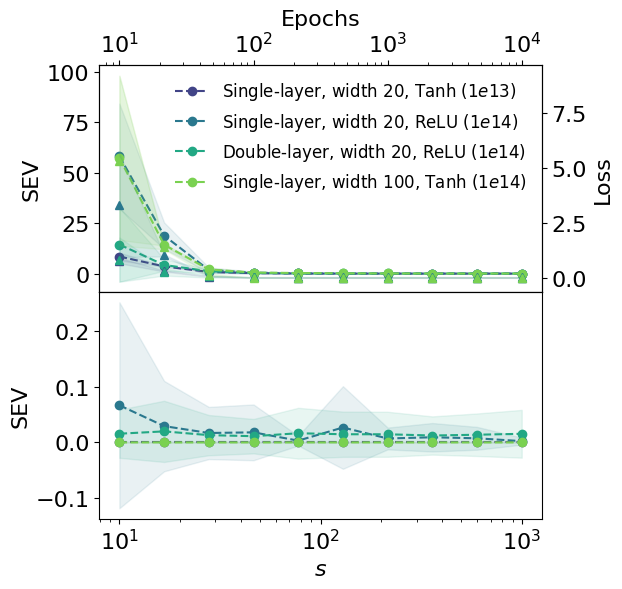

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import torch
from math import floor,log10

results_dict = torch.load('paper/convergence_result_dict_ck.pt')

label_dict = {'tanh_single_20': 'Single-layer, width 20, Tanh',
              'relu_single_20': 'Single-layer, width 20, ReLU',
              'relu_double_20': 'Double-layer, width 20, ReLU',
              'tanh_single_80': 'Single-layer, width 100, Tanh'}

w, h, fs = 6, 6, 16
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(w,h),frameon=True,)
# color = cm.rainbow(np.linspace(0, 1, 4))

color = plt.cm.viridis(np.linspace(0.2,0.8,4))

ax1t = ax1.twinx()
ax1.set_ylabel('SEV', fontsize=fs)
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)
ax2.set_ylabel('SEV', fontsize=fs)
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

for i,key in enumerate(results_dict.keys()):
    exponent = int(floor(log10(abs(results_dict[key]['cond_avg']))))
    ax1.plot(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'],
             color=color[i],marker='o',linestyle='dashed',
             label=label_dict[key] + f" ($1e{exponent}$)"
    )
    ax1.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             color=color[i],alpha=0.1)
    
    ax1t.plot(results_dict[key]['epoch_range'],
              results_dict[key]['epoch_loss_avg'],
              color=color[i],marker='^',linestyle='none')
    ax1t.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             results_dict[key]['epoch_loss_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             color=color[i],alpha=0.1)
    
    ax2.plot(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'],color=color[i],marker='o',linestyle='dashed',)
    ax2.fill_between(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             results_dict[key]['s_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             color=color[i],alpha=0.1)

ax1.legend(fontsize=int(fs * 0.75), frameon=False)
# ax2.set_xlim(s_range[0],s_range[-1])
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fname='paper/epochs_ck_convergence.pdf', format='pdf', bbox_inches='tight')

In [8]:
for i,key in enumerate(results_dict.keys()):
    print(key)
    print(results_dict[key]['cond_avg'])
    print(results_dict[key]['s_sev_avg'])

tanh_single_20
tensor(8.4399e+10)
tensor([3.0276e-09, 3.0276e-09, 3.0276e-09, 3.0276e-09, 3.0276e-09])
relu_single_20
tensor(3.6691e+11)
tensor([0.0526, 0.0217, 0.0169, 0.0049, 0.0003])
relu_double_20
tensor(3.5131e+11)
tensor([2.6942e-08, 3.6217e-08, 4.3508e-08, 4.1543e-08, 4.1103e-08])
tanh_single_80
tensor(2.5798e+11)
tensor([0.0627, 0.0540, 0.0423, 0.0427, 0.0439])


# NTK vs CK

In [39]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=True) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],1, bias=True)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)

def convergence(n,d,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx_ntk(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J

    lam = 1e-12
    Jtrain = Jx_ntk(X)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')
    print(f'Rank: {torch.linalg.matrix_rank(Jtrain)}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx_ntk(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)

    def Jx_ck(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = J[-2].detach().flatten(1).detach() # For last-layer test
        return J
    
    lam = 1e-12
    Jtrain = Jx_ck(X)
    CK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(CK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')
    print(f'Rank: {torch.linalg.matrix_rank(Jtrain)}')

    var_ck = []
    for xi in X_test:
        Jsingle = Jx_ck(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(CK_X,KXx)
        var_ck.append(var)
    var_ck = torch.tensor(var_ck)

    return torch.linalg.norm(var_ck - var_ntk).item()


In [40]:
samples = 1
n = 100
d = 5
results_dict = {}

# single-layer, width=20, tanh

layer_widths = [d,20]

for i in range(samples):
    ck_ntk_diff = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)

print(f'single-layer, width=20, tanh, diff: {ck_ntk_diff}')

# single-layer, width=20, relu

layer_widths = [d,20]

for i in range(samples):
    ck_ntk_diff = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)

print(f'single-layer, width=20, relu, diff: {ck_ntk_diff}')

# # double-layer, width=20, relu
# print(f'double-layer, width=20, relu')
# layer_widths = [d,20,20]

# diff_e_av = []
# losses_e_av = []
# diff_s_av = []
# conds = []

# for i in range(samples):
#     diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
#     diff_e_av.append(diff_e)
#     losses_e_av.append(losses_e)
#     diff_s_av.append(diff_s)
#     conds.append(cond_i)

# epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
# epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
# s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
# cond_avg = torch.tensor(conds).mean(0)
# results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
#                                   'epoch_sev_var': epoch_sev_var,
#                                   'epoch_loss_avg': epoch_loss_avg,
#                                   'epoch_loss_var': epoch_loss_var,
#                                   's_sev_avg': s_sev_avg,
#                                   's_sev_var': s_sev_var,
#                                   'cond_avg': cond_avg,
#                                   'epoch_range': epochs,
#                                   's_range': s_range}
# torch.save(results_dict,'paper/convergence_result_dict.pt')

# # single-layer, width=80, tanh
# print(f'single-layer, width=80, tanh')
# layer_widths = [d,80]

# diff_e_av = []
# losses_e_av = []
# diff_s_av = []
# conds = []

# for i in range(samples):
#     diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
#     diff_e_av.append(diff_e)
#     losses_e_av.append(losses_e)
#     diff_s_av.append(diff_s)
#     conds.append(cond_i)

# epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
# epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
# s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
# cond_avg = torch.tensor(conds).mean(0)
# results_dict['tanh_single_80'] = {'epoch_sev_avg': epoch_sev_avg,
#                                   'epoch_sev_var': epoch_sev_var,
#                                   'epoch_loss_avg': epoch_loss_avg,
#                                   'epoch_loss_var': epoch_loss_var,
#                                   's_sev_avg': s_sev_avg,
#                                   's_sev_var': s_sev_var,
#                                   'cond_avg': cond_avg,
#                                   'epoch_range': epochs,
#                                   's_range': s_range}
# torch.save(results_dict,'paper/convergence_result_dict_ck.pt')



nn loss : 3.5e-07
Cond(J J^T) = 7e+03
Rank: 100
Cond(J J^T) = 9e+13
Rank: 20
single-layer, width=20, tanh, diff: 15.795949550828457


C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


nn loss : 0.1063
Cond(J J^T) = 4e+04
Rank: 100
Cond(J J^T) = 8e+14
Rank: 20
single-layer, width=20, relu, diff: 19.87314539541433


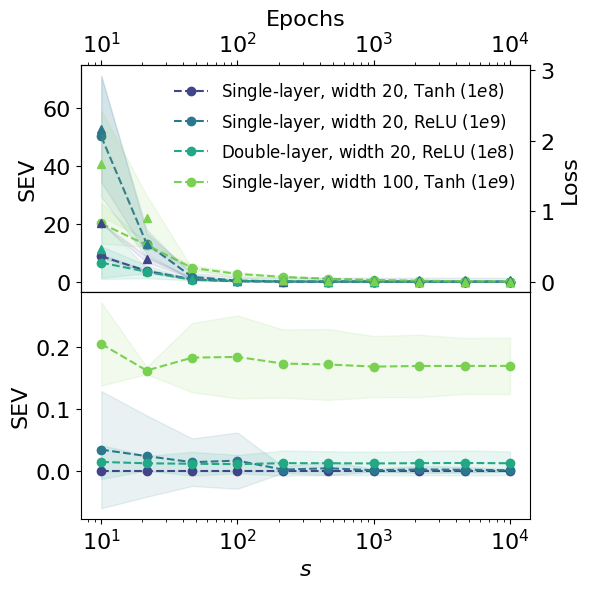

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import torch
from math import floor,log10

results_dict = torch.load('paper/convergence_result_dict_ck.pt')

label_dict = {'tanh_single_20': 'Single-layer, width 20, Tanh',
              'relu_single_20': 'Single-layer, width 20, ReLU',
              'relu_double_20': 'Double-layer, width 20, ReLU',
              'tanh_single_80': 'Single-layer, width 100, Tanh'}

w, h, fs = 6, 6, 16
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(w,h),frameon=True,)
# color = cm.rainbow(np.linspace(0, 1, 4))

color = plt.cm.viridis(np.linspace(0.2,0.8,4))

ax1t = ax1.twinx()
ax1.set_ylabel('SEV', fontsize=fs)
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)
ax2.set_ylabel('SEV', fontsize=fs)
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

for i,key in enumerate(results_dict.keys()):
    exponent = int(floor(log10(abs(results_dict[key]['cond_avg']))))
    ax1.plot(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'],
             color=color[i],marker='o',linestyle='dashed',
             label=label_dict[key] + f" ($1e{exponent}$)"
    )
    ax1.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             color=color[i],alpha=0.1)
    
    ax1t.plot(results_dict[key]['epoch_range'],
              results_dict[key]['epoch_loss_avg'],
              color=color[i],marker='^',linestyle='none')
    ax1t.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             results_dict[key]['epoch_loss_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             color=color[i],alpha=0.1)
    
    ax2.plot(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'],color=color[i],marker='o',linestyle='dashed',)
    ax2.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['s_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             results_dict[key]['s_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             color=color[i],alpha=0.1)

ax1.legend(fontsize=int(fs * 0.75), frameon=False)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(fname='paper/epochs_ck_convergence.pdf', format='pdf')

# Classification

In [66]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm
from nuqls.posterior import Nuqls

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin,num_output):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=True) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],num_output, bias=True)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)

def convergence(n,d,c,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randint(low=0, high=2, size=(n,))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin,num_output=c)

    optimizer = torch.optim.SGD(net.parameters(),lr=1e-0,momentum=0.9)
    loss_fn = torch.nn.CrossEntropyLoss()
    for i in range(10000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    if verbose:
        total_norm = 0
        for p in net.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        print(f'Gradient norm : {total_norm:.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(2) for j in J]
        J = torch.cat(J,dim=2).detach()
        return J

    lam = 0
    scale = 1
    Jtrain = Jx(X).flatten(0,1)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n*c)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')
    print(f'Rank: {torch.linalg.matrix_rank(Jtrain)}')
    print(f'min eigenv: {torch.linalg.eigvalsh(NTK_X).min()}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0)).flatten(0,1)
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.stack(var_ntk)*scale
    var_ntk = torch.diagonal(var_ntk, dim1 = - 2, dim2 = -1)
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):

        nuqls_posterior = Nuqls(net, task='classification')
        loss,_ = nuqls_posterior.train(train=train_data, 
                                            train_bs=n, 
                                            n_output=c,
                                            S=100,
                                            scale=scale, 
                                            lr=lr, 
                                            epochs=int(epoch.item()), 
                                            mu=0.9,
                                            verbose=False
                                            )

        nuql_test_preds = nuqls_posterior.test(test_data, n)
        var_nuqls = nuql_test_preds.var(0)
        print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_e.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss:.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,3,10)
    for s in tqdm.tqdm(s_range):

        nuqls_posterior = Nuqls(net, task='classification')
        loss,_ = nuqls_posterior.train(train=train_data, 
                                            train_bs=n, 
                                            n_output=c,
                                            S=int(s.item()),
                                            scale=scale, 
                                            lr=lr, 
                                            epochs=10000, 
                                            mu=0.9,
                                            verbose=False
                                            )

        nuql_test_preds = nuqls_posterior.test(test_data, n)
        var_nuqls = nuql_test_preds.var(0)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_s.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range,cond


In [67]:
samples = 2
n = 100
d = 5
c = 3
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,120]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,c,layer_widths=layer_widths,nonlin='tanh',lr=1e-1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

single-layer, width=20, tanh
nn loss : 5.566e-05
Gradient norm : 2.479e-05
Cond(J J^T) = 1e+04
Rank: 300
min eigenv: 0.1226845111002593


 10%|█         | 1/10 [00:00<00:02,  3.70it/s]

epoch: 10.0, convergence = 572.4914298239108
--------------------------------------
epoch: 10, nuqls loss : 1.138


 20%|██        | 2/10 [00:00<00:03,  2.36it/s]

epoch: 21.544346900318832, convergence = 534.2317961735678
--------------------------------------
epoch: 21, nuqls loss : 0.242


 30%|███       | 3/10 [00:01<00:05,  1.31it/s]

epoch: 46.41588833612777, convergence = 523.709846633209
--------------------------------------
epoch: 46, nuqls loss : 0.008313


 30%|███       | 3/10 [00:02<00:06,  1.01it/s]


KeyboardInterrupt: 

In [29]:
samples = 2
n = 100
d = 5
c = 3
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,c,layer_widths=layer_widths,nonlin='tanh',lr=1e-1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# # single-layer, width=20, relu
# print(f'single-layer, width=20, relu')
# layer_widths = [d,20]

# diff_e_av = []
# losses_e_av = []
# diff_s_av = []
# conds = []

# for i in range(samples):
#     diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
#     diff_e_av.append(diff_e)
#     losses_e_av.append(losses_e)
#     diff_s_av.append(diff_s)
#     conds.append(cond_i)

# epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
# epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
# s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
# cond_avg = torch.tensor(conds).mean(0)
# results_dict['relu_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
#                                   'epoch_sev_var': epoch_sev_var,
#                                   'epoch_loss_avg': epoch_loss_avg,
#                                   'epoch_loss_var': epoch_loss_var,
#                                   's_sev_avg': s_sev_avg,
#                                   's_sev_var': s_sev_var,
#                                   'cond_avg': cond_avg,
#                                   'epoch_range': epochs,
#                                   's_range': s_range}
# torch.save(results_dict,'paper/convergence_result_dict.pt')

# # double-layer, width=20, relu
# print(f'double-layer, width=20, relu')
# layer_widths = [d,20,20]

# diff_e_av = []
# losses_e_av = []
# diff_s_av = []
# conds = []

# for i in range(samples):
#     diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
#     diff_e_av.append(diff_e)
#     losses_e_av.append(losses_e)
#     diff_s_av.append(diff_s)
#     conds.append(cond_i)

# epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
# epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
# s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
# cond_avg = torch.tensor(conds).mean(0)
# results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
#                                   'epoch_sev_var': epoch_sev_var,
#                                   'epoch_loss_avg': epoch_loss_avg,
#                                   'epoch_loss_var': epoch_loss_var,
#                                   's_sev_avg': s_sev_avg,
#                                   's_sev_var': s_sev_var,
#                                   'cond_avg': cond_avg,
#                                   'epoch_range': epochs,
#                                   's_range': s_range}
# torch.save(results_dict,'paper/convergence_result_dict.pt')

# # single-layer, width=80, tanh
# print(f'single-layer, width=80, tanh')
# layer_widths = [d,80]

# diff_e_av = []
# losses_e_av = []
# diff_s_av = []
# conds = []

# for i in range(samples):
#     diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=1,verbose=True)
#     diff_e_av.append(diff_e)
#     losses_e_av.append(losses_e)
#     diff_s_av.append(diff_s)
#     conds.append(cond_i)

# epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
# epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
# s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
# cond_avg = torch.tensor(conds).mean(0)
# results_dict['tanh_single_80'] = {'epoch_sev_avg': epoch_sev_avg,
#                                   'epoch_sev_var': epoch_sev_var,
#                                   'epoch_loss_avg': epoch_loss_avg,
#                                   'epoch_loss_var': epoch_loss_var,
#                                   's_sev_avg': s_sev_avg,
#                                   's_sev_var': s_sev_var,
#                                   'cond_avg': cond_avg,
#                                   'epoch_range': epochs,
#                                   's_range': s_range}
# torch.save(results_dict,'paper/convergence_result_dict_ck.pt')



single-layer, width=20, tanh
nn loss : 0.0001414
Cond(J J^T) = 1e+12
Rank: 183
min eigenv: 9.998717815982123e-10


100%|██████████| 10/10 [00:00<00:00, 195.33it/s, min_loss=0.0852, max_loss=1.01, min_acc=0.82, max_acc=0.97, resid_norm=0.000855, gpu_mem=0]


Posterior samples computed!
epoch: 10.0, convergence = 568.589622442282
--------------------------------------
epoch: 10, nuqls loss : 1.014


 20%|██        | 2/10 [00:00<00:00,  8.29it/s]

Posterior samples computed!
epoch: 21.544346900318832, convergence = 461.44584671843575
--------------------------------------
epoch: 21, nuqls loss : 0.3809


 30%|███       | 3/10 [00:00<00:01,  5.01it/s]

Posterior samples computed!
epoch: 46.41588833612777, convergence = 426.220698446344
--------------------------------------
epoch: 46, nuqls loss : 0.01284


 30%|███       | 3/10 [00:01<00:02,  2.57it/s]


KeyboardInterrupt: 